### Install and Import Dependencies

In [33]:
%pip install pandas
%pip install scipy
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install numpy
%pip install imbalanced-learn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note

In [34]:
# For loading/processing data
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# For evaluating Classifier
from sklearn import metrics
# For Random Upsampling
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml
from imblearn.over_sampling import SMOTE, ADASYN


### Load Dataset

In [4]:
# Load in the arff file
arff_file = arff.loadarff('data/seismic-bumps.arff')
# Convert to a pandas dataframe
data = pd.DataFrame(arff_file[0])

# Get shape of dataframe: (rows, columns)
print(data.shape)

# Visualize the dataframe
data.sample(5)

(2584, 19)


,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
2104,b'a',b'a',b'N',7080.0,260.0,-41.0,5.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1355,b'a',b'b',b'W',10270.0,306.0,-31.0,-19.0,b'b',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1485,b'a',b'a',b'N',19560.0,659.0,123.0,121.0,b'a',1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,700.0,b'0'
373,b'a',b'a',b'N',3170.0,36.0,-88.0,-79.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1632,b'b',b'b',b'W',14890.0,540.0,-64.0,-53.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


### Explore Dataset

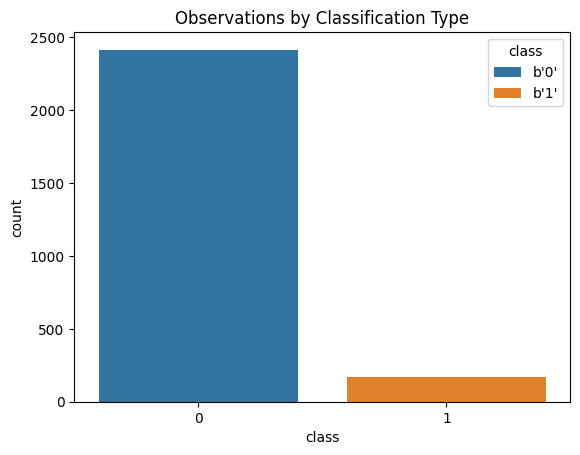

In [5]:
# TODO: add documentation links

# Create a bar chart to plot counts of each class
ax = sns.countplot(x = data['class'], hue=data['class'])

# Add plot title
plt.title("Observations by Classification Type")

# show plot
plt.show()

### Process/Split Dataset

In [6]:
# TODO: maybe replace labels to something more understandable?

# We only want 2 variables for this classifier so we can visualize in a plot
# The two columns we will get is gpuls and gdenergy
# No data cleaning is needed: this dataset has no nulls

# Also split into input, X, and output, Y
# Shape: (2584, 14)
X = data.iloc[:,[3, 4]]
# Shape: (2584, 1)
Y = data.iloc[:,-1].astype(np.float32)
# Output a few rows of each data
display(X.head(5))
display(Y.head(5))

,genergy,gpuls
0,15180.0,48.0
1,14720.0,33.0
2,8050.0,30.0
3,28820.0,171.0
4,12640.0,57.0


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: class, dtype: float32

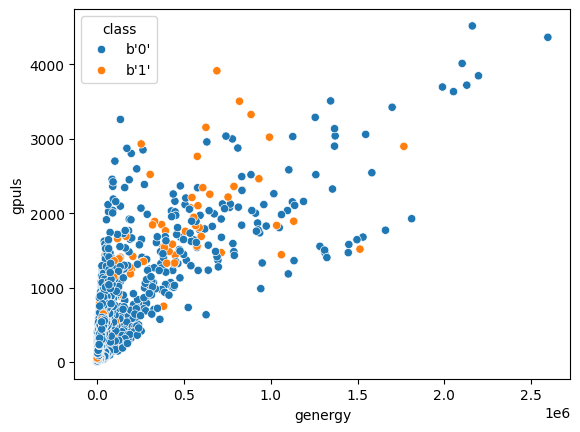

In [7]:
# Plot the input data with the majority and minority class
ax = sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class')
plt.show()

In [8]:
# Split the data into the train and test set
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Random Forest Scikit-learn

### Baseline Model

In [9]:
# Make the classifier. 
# Using default values except:
# Max depth of each tree is 2
# The randomn_state sets the seed for the randomness in bootstrapping the data for each decision tree
classifier = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

### Evaluation with Performance Metrics

In [10]:
# Running the test set through the model
# This function outputs the probability for each class
baseline_output = classifier.predict_proba(X_test)
# Peak into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(baseline_output[:10])
# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob = baseline_output[:, 1]

[[0.9378409  0.0621591 ]
 [0.92833102 0.07166898]
 [0.92833102 0.07166898]
 [0.90615054 0.09384946]
 [0.97315698 0.02684302]
 [0.93725957 0.06274043]
 [0.9790075  0.0209925 ]
 [0.9790075  0.0209925 ]
 [0.97182634 0.02817366]
 [0.75653331 0.24346669]]


In [11]:
# Getting the ROC curve and plotting
baseline_fpr, baseline_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob, pos_label=1)

# Finding the AUC score
baseline_roc_auc = metrics.auc(baseline_fpr, baseline_tpr)

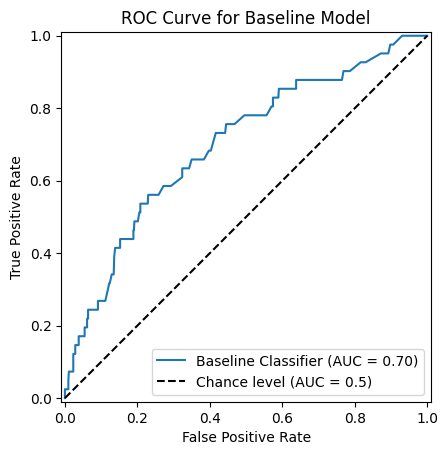

In [12]:
# Plotting the ROC curve
baseline_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob, 
    pos_label=1,
    name='Baseline Classifier', 
    plot_chance_level=True # Plots the ROC curve for a random classifier
)

# Labeling and TItling the Plot
plt.title("ROC Curve for Baseline Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [13]:
# Get precision recall on test set
baseline_precision, baseline_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob)

# Getting the AUC
baseline_pr_auc = metrics.auc(baseline_recall, baseline_precision)

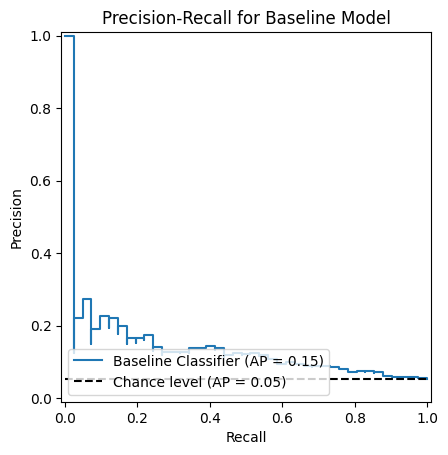

In [14]:
# Plotting the P-R Curve
baseline_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob,
    pos_label = 1,
    name = "Baseline Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Baseline Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

## Upsampling Techniques

### Random Upsampling

In [15]:
# Get the data for each class
b0_df = X_train[Y_train == 0.0]
b1_df = X_train[Y_train == 1.0]
b0_num_rows = len(b0_df)
b1_num_rows = len(b1_df)

In [16]:
# Displaying ratios of classes
print('Percentage of class 0 training data before random upsampling:', round((b0_num_rows/len(Y_train)) * 100, 2), '%')
print('Percentage of class 1 training data before random upsampling:', round((b1_num_rows/len(Y_train)) * 100, 2), '%')

Percentage of class 0 training data before random upsampling: 92.87 %
Percentage of class 1 training data before random upsampling: 7.13 %


In [17]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html
# Upsample by randomly sampling the minority class
b1_upsampled_df = resample(b1_df, random_state=42, n_samples=b0_num_rows, replace=True)
b0_upsampled_df = b0_df

In [18]:
b1_upsampled_rows = len(b1_upsampled_df)
b0_upsampled_rows = len(b0_upsampled_df)

In [19]:
X_train_upsampled = pd.concat([b0_upsampled_df, b1_upsampled_df]).reset_index(drop=True)
Y_train_upsampled = pd.concat([pd.Series([0.0 for _ in range(b1_upsampled_rows)]), pd.Series([1.0 for _ in range(b0_upsampled_rows)])]).reset_index(drop=True)
Y_train_upsampled.name='class'

In [20]:
print('Percentage of b0 training data after random upsampling:', round((b0_upsampled_rows/len(X_train_upsampled)) * 100, 2), '%')
print('Percentage of b1 training data after random upsampling:', round((b1_upsampled_rows/len(X_train_upsampled)) * 100, 2), '%')

Percentage of b0 training data after random upsampling: 50.0 %
Percentage of b1 training data after random upsampling: 50.0 %


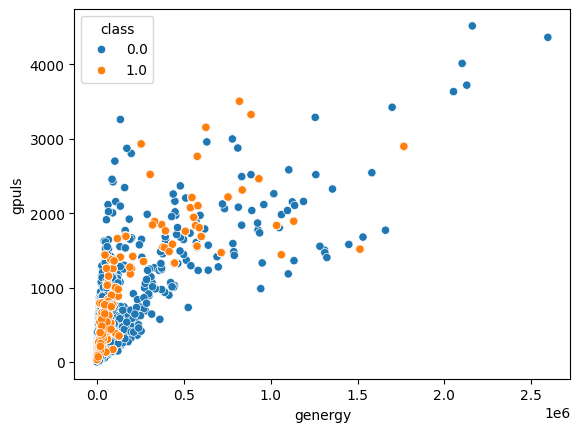

In [21]:
# Put data into dataframe for plotting
df_random_upsampled = pd.concat([X_train_upsampled, Y_train_upsampled], axis=1)

# Plot the data now
ax = sns.scatterplot(df_random_upsampled, x='genergy', y='gpuls', hue='class')
plt.show()

In [22]:
# Make the classifier. 
# Using default values except:
# Max depth of each tree is 2
# The randomn_state sets the seed for the randomness in bootstrapping the data for each decision tree
classifier_randomly_upsampled = RandomForestClassifier(max_depth=2, random_state=0)

# Train the classifier
classifier_randomly_upsampled.fit(X_train_upsampled, Y_train_upsampled)

RandomForestClassifier(max_depth=2, random_state=0)

In [23]:
# Running the test set through the model
# This function outputs the probability for each class
upsampled_output = classifier_randomly_upsampled.predict_proba(X_test)
# Peak into a few predicted output probabilities: (probability of class 0, probability of class 1)
print(upsampled_output[:10])
# Grab the predicted probabilities for class 1 (We treat this as the positive, minority class)
y_class1_pred_prob_upsampled = upsampled_output[:, 1]

[[0.49516754 0.50483246]
 [0.4919555  0.5080445 ]
 [0.4919555  0.5080445 ]
 [0.48832357 0.51167643]
 [0.79237272 0.20762728]
 [0.49516754 0.50483246]
 [0.80998483 0.19001517]
 [0.80998483 0.19001517]
 [0.79237272 0.20762728]
 [0.3940732  0.6059268 ]]


In [24]:
# Getting the ROC curve and plotting
upsampled_fpr, upsampled_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_upsampled, pos_label=1)

# Finding the AUC score
upsampled_roc_auc = metrics.auc(upsampled_fpr, upsampled_tpr)

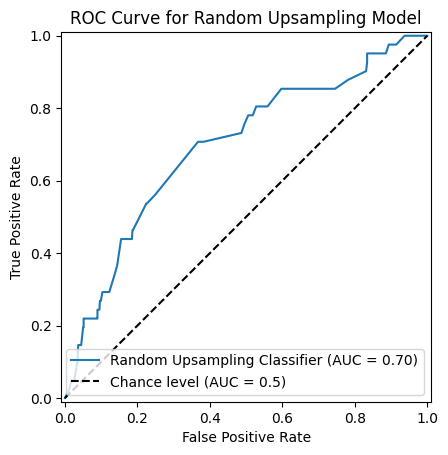

In [25]:
# Plotting the ROC curve
upsampled_display_roc = metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_upsampled, 
    pos_label=1,
    name='Random Upsampling Classifier', 
    plot_chance_level=True, # Plots the ROC curve for a random classifier
)

# Labeling and TItling the Plot
plt.title("ROC Curve for Random Upsampling Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [26]:
# Get precision recall on test set
upsampled_precision, upsampled_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_upsampled)

# Getting the AUC
upsampled_pr_auc = metrics.auc(upsampled_recall, upsampled_precision)

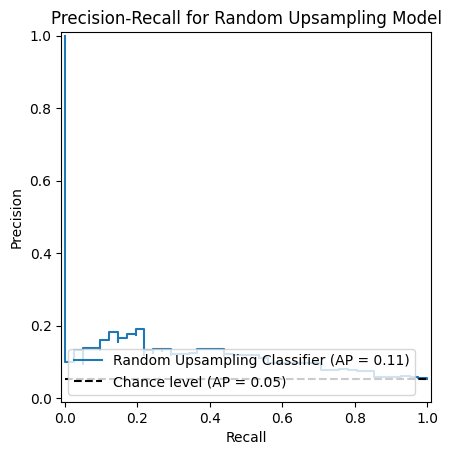

In [27]:
# Plotting the P-R Curve
upsampled_display_pr = metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_upsampled,
    pos_label = 1,
    name = "Random Upsampling Classifier",
    plot_chance_level=True # Plots the PR curve of a random classifier
)

# Labeling the plot
plt.title("Precision-Recall for Random Upsampling Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

### SMOTE

In [31]:
# Recall this is the intial dataset with no upsampling yet
b0_df = X_train[Y_train == 0.0]
b1_df = X_train[Y_train == 1.0]
b0_num_rows = len(b0_df)
b1_num_rows = len(b1_df)

print('Percentage of class 0 training data before random upsampling:', round((b0_num_rows/len(Y_train)) * 100, 2), '%')
print('Percentage of class 1 training data before random upsampling:', round((b1_num_rows/len(Y_train)) * 100, 2), '%')

Percentage of class 0 training data before random upsampling: 92.87 %
Percentage of class 1 training data before random upsampling: 7.13 %


Before:  Counter({0.0: 1679, 1.0: 129})
After:  Counter({0.0: 1679, 1.0: 1679})


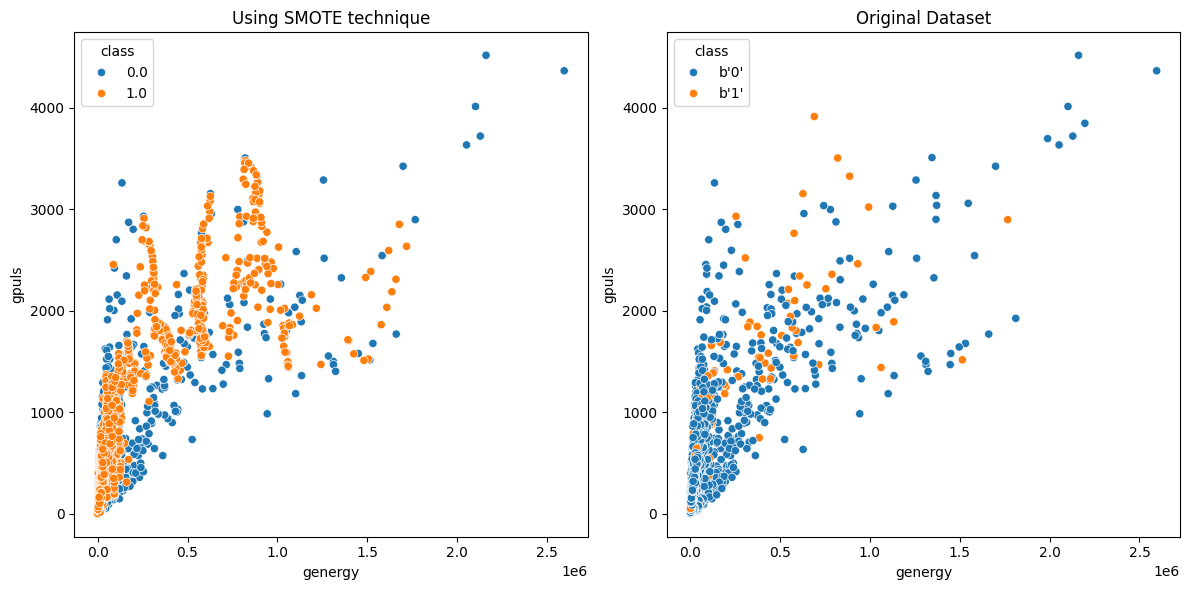

In [46]:
from collections import Counter


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

counter = Counter(Y_train)
smt = SMOTE()
print('Before: ', counter)
X_train_resampled, Y_train_resampled = smt.fit_resample(X_train, Y_train)
counter = Counter(Y_train_resampled)
print('After: ', counter)


randomUpDf = pd.concat([X_train_resampled, Y_train_upsampled], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=randomUpDf, x='genergy', y='gpuls', hue='class', ax=axes[0])
axes[0].set_title('Using SMOTE technique')
sns.scatterplot(data=data, x='genergy', y='gpuls', hue='class', ax=axes[1])
axes[1].set_title('Original Dataset')
plt.tight_layout()
plt.show()

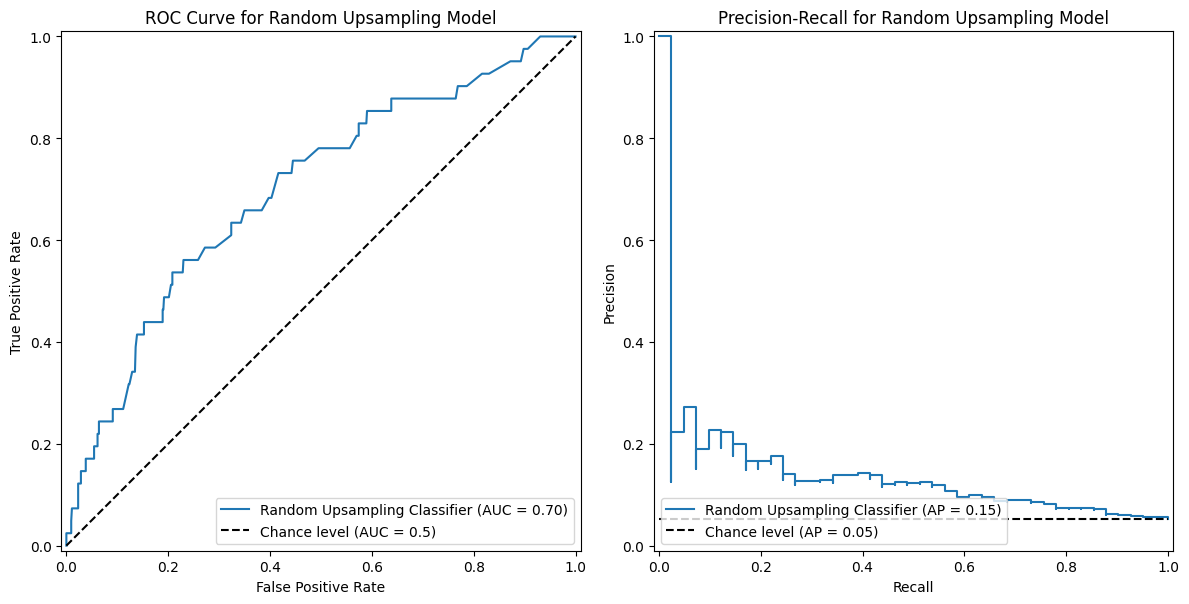

In [57]:
# I feel like we should embedded this code in like a drop down to save space because most of it is repeat stuff
# If the user wants to look at it again then sure let them, but at the end we should compare all ROC curves
# Building the actual classifier using SMOTE
my_model = RandomForestClassifier(max_depth=2, random_state=0)
my_model.fit(X_train, Y_train)
output = my_model.predict_proba(X_test)
y_class1_pred_prob_upsampled = output[:, 1]
upsampled_fpr, upsampled_tpr, _ = metrics.roc_curve(Y_test, y_class1_pred_prob_upsampled, pos_label=1)
upsampled_roc_auc = metrics.auc(upsampled_fpr, upsampled_tpr)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC Curve
metrics.RocCurveDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_upsampled, 
    pos_label=1,
    name='Random Upsampling Classifier', 
    plot_chance_level=True,
    ax=axes[0]
)
axes[0].set_title("ROC Curve for Random Upsampling Model")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")

# Plot the Precision-Recall curve
upsampled_precision, upsampled_recall, _ = metrics.precision_recall_curve(Y_test, y_class1_pred_prob_upsampled)
upsampled_pr_auc = metrics.auc(upsampled_recall, upsampled_precision)
metrics.PrecisionRecallDisplay.from_predictions(
    Y_test,
    y_class1_pred_prob_upsampled,
    pos_label = 1,
    name = "Random Upsampling Classifier",
    plot_chance_level=True,
    ax=axes[1]
)
axes[1].set_title("Precision-Recall for Random Upsampling Model")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")

# Adjust layout and display
plt.tight_layout()
plt.show()


### OPTIONAL: Borderline SMOTE